Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Python. Uczenie maszynowe - kod źródłowy

# Rozdział 7. Łączenie różnych modeli w celu uczenia zespołowego

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

Sebastian Raschka 
last updated: 2019-12-05 

CPython 3.7.1
IPython 7.10.1

numpy 1.17.4
pandas 0.25.3
matplotlib 3.1.1
scipy 1.3.1
sklearn 0.22


*Korzystanie z rozszerzenia `watermark` nie jest obowiązkowe. Możesz je zainstalować za pomocą polecenia:*  

    conda install watermark -c conda-forge  

lub  

    pip install watermark   

*Więcej informacji znajdziesz pod adresem: https://github.com/rasbt/watermark.*

<br>
<br>

### Spis treści

- [Uczenie zespołów](#Uczenie-zespołów)
- [Łączenie klasyfikatorów za pomocą algorytmu głosowania większościowego](#Łączenie-klasyfikatorów-za-pomocą-algorytmu-głosowania-większościowego)
    - [Implementacja prostego klasyfikatora głosowania większościowego](#Implementacja-prostego-klasyfikatora-głosowania-większościowego)
    - [Stosowanie reguły głosowania większościowego do uzyskiwania prognoz](#Stosowanie-reguły-głosowania-większościowego-do-uzyskiwania-prognoz)
    - [Ewaluacja i strojenie klasyfikatora zespołowego](#Ewaluacja-i-strojenie-klasyfikatora-zespołowego)
- [Agregacja — tworzenie zespołu klasyfikatorów za pomocą próbek początkowych](#Agregacja-—-tworzenie-zespołu-klasyfikatorów-za-pomocą-próbek-początkowych)
    - [Agregacja w pigułce](#Agregacja-w-pigułce)
    - [Stosowanie agregacji do klasyfikowania przykładów z zestawu Wine](#Stosowanie-agregacji-do-klasyfikowania-przykładów-z-zestawu-Wine)
- [Usprawnianie słabych klasyfikatorów za pomocą wzmocnienia adaptacyjnego](#Usprawnianie-słabych-klasyfikatorów-za-pomocą-wzmocnienia-adaptacyjnego)
    - [Wzmacnianie — mechanizm działania](#Wzmacnianie-—-mechanizm-działania)
    - [Stosowanie algorytmu AdaBoost za pomocą biblioteki scikit-learn](#Stosowanie-algorytmu-AdaBoost-za-pomocą-biblioteki-scikit-learn)
- [Podsumowanie](#Podsumowanie)

<br>
<br>

In [1]:
from IPython.display import Image
%matplotlib inline

# Uczenie zespołów

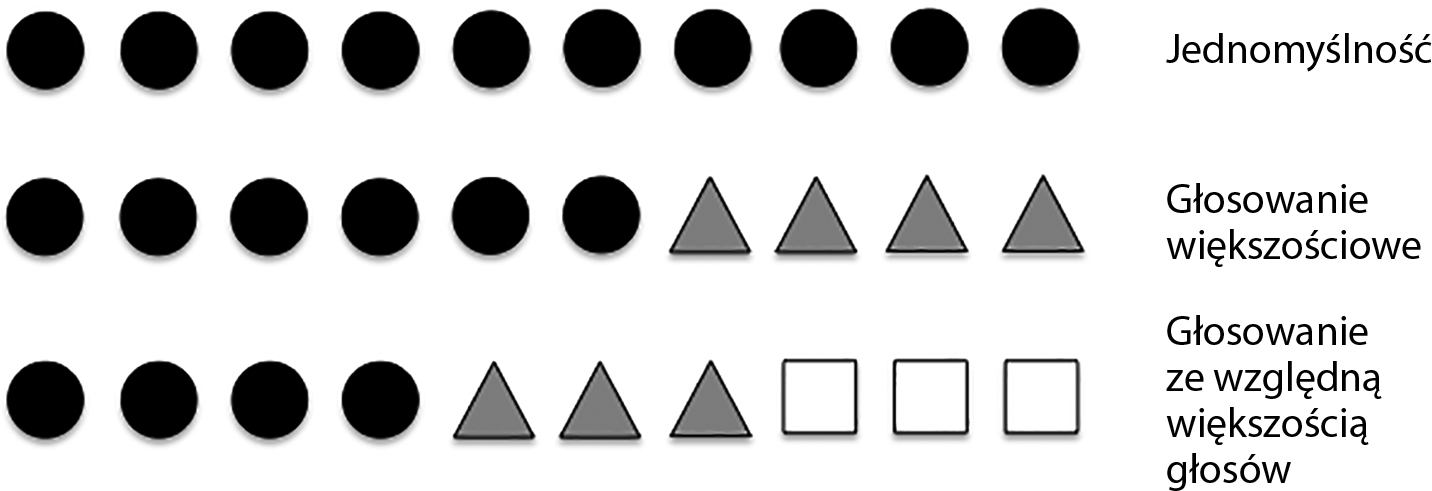

In [2]:
Image(filename='rysunki/07_01.png', width=500) 

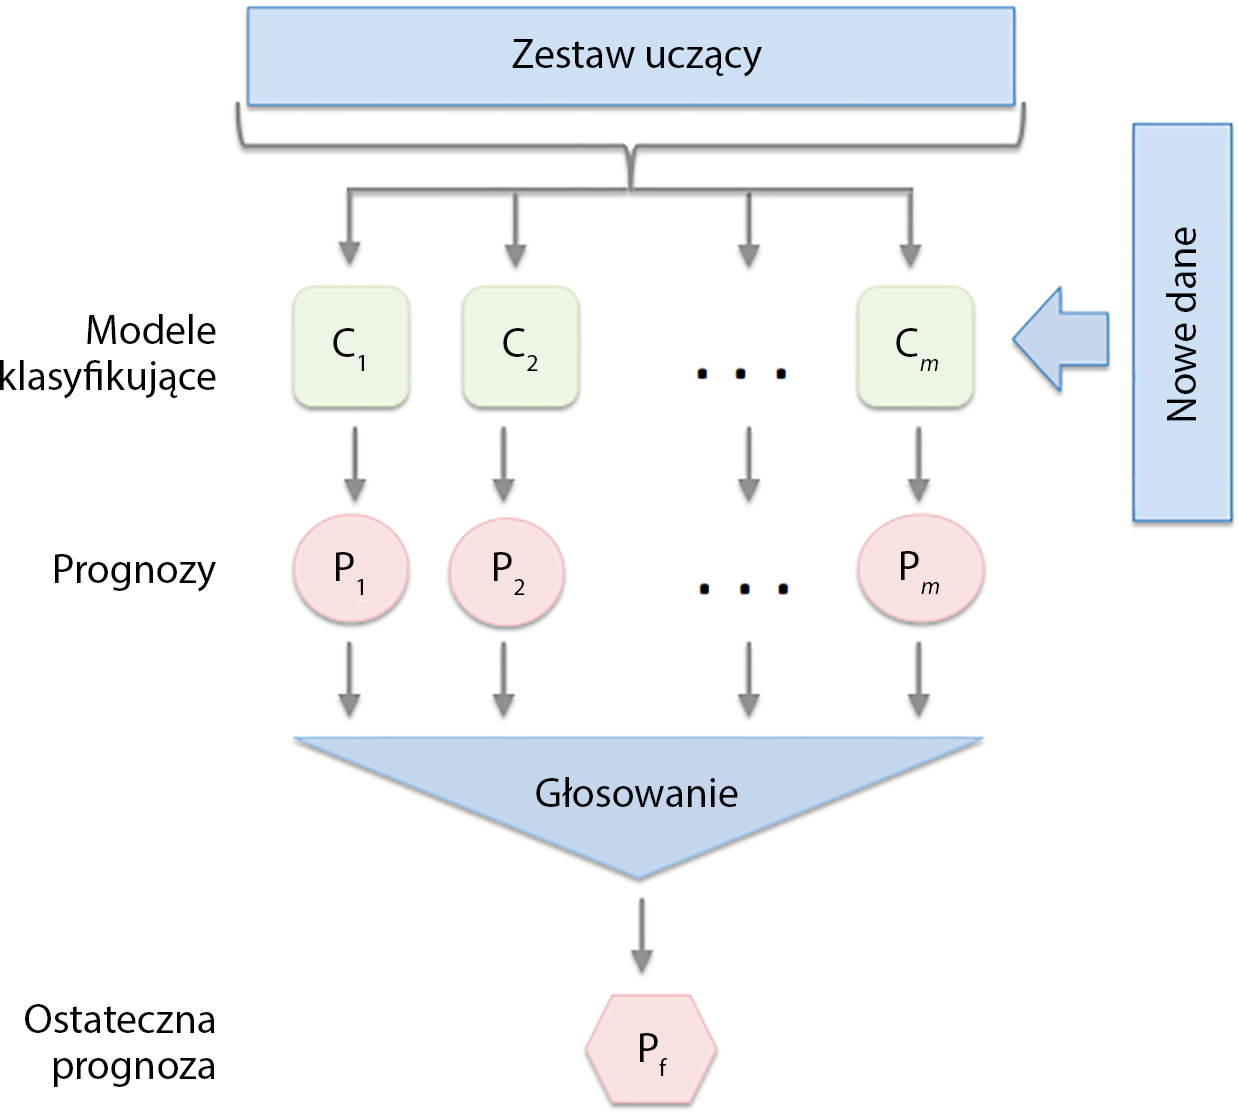

In [3]:
Image(filename='rysunki/07_02.png', width=500) 

In [5]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [6]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [7]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

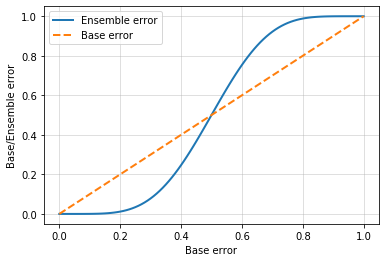

In [8]:
import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Błąd zespołowy', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Błąd bazowy',
         linewidth=2)

plt.xlabel('Błąd bazowy')
plt.ylabel('Współczynnik błędu bazowego/zespołowego')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
#plt.savefig('rysunki/07_03.png', dpi=300)
plt.show()

<br>
<br>

# Łączenie klasyfikatorów za pomocą algorytmu głosowania większościowego

## Implementacja prostego klasyfikatora głosowania większościowego

In [9]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

In [10]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [11]:
np.argmax(p)

0

In [12]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ Klasyfikator zespołowy (głosowanie większościowe)

    Parametry
    ----------
    classifiers : tablicopodobny, wymiary = [n_klasyfikatorów]
      Różne klasyfikatory tworzące zespół

    vote : łańcuch znaków, {'classlabel', 'probability'} (domyślnie: 'classlabel')
      Jeżeli jest wybrany argument 'classlabel', to prognoza jest przeprowadzana przy użyciu funkcji
        argmax wobec etykiet klas. W przeciwnym wypadku ('probability'), wynik funkcji argmax wobec sumy
        prawdopodobieństw zostaje użyty do prognozowania etykiety klas (zalecane dla skalibrowanych klasyfikatorów).

    weights : tablicopodobne, wymiary = [n_klasyfikatorów], Opcjonalny, (domyślnie: None)
      Po wprowadzeniu listy wartości typu `int` lub `float`, Klasyfikatory są ważone pod kątem ważności. Jeśli
      `weights=None`, wykorzystywane są takie same wagi.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Dopasowywanie klasyfikatorów.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Macierz próbek uczących.

        y : tablicopodobny, wymairy = [n_próbek]
            Wektor docelowych etykiet klas.

        Zwraca
        -------
        self : obiekt

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("parametr vote przyjmuje wyłącznie wartości 'probability' lub 'classlabel'"
                             "; wybrano (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Liczba klasyfikatorów musi być równa liczbie wag'
                             '; dostępne wagi: %d, klasyfikatory: %d'
                             % (len(self.weights), len(self.classifiers)))

        # dzięki klasie LabelEncoder etykiety klas rozpoczynają się 
        # od wartości 0, co jest bardzo ważne podczas wywołania np.argmax
        # w self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Prognozowanie etykiet klas dla próbki X.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Macierz próbek uczących.

        Zwraca
        ----------
        maj_vote : tablicopodobny, wymiary = [n_próbek]
            Przewidywane etykiety klas.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # wartość 'classlabel'

            #  zbiera wyniki z wywołań metody clf.predict
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Prognozowania prawdopodobieństwa przynależności próbki X do danej klasy.

        Parametry
        ----------
        X : {tablicopodobny, macierz rzadka}, wymiary = [n_próbek, n_cech]
            Wektory uczenia, gdzie n_próbek oznacza
            liczbę próbek, a n_cech – liczbę cech.

        Zwraca
        ----------
        avg_proba : tablicopodobny, wymiary = [n_próbek, n_klas]
            Ważone, uśrednione prawdopodobieństwo wystąpienia każdej klasy na daną próbkę.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Pobiera nazwy parametrów klasyfikatora dla klasy GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

<br>
<br>

## Stosowanie reguły głosowania większościowego do uzyskiwania prognoz

In [13]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Regresja logistyczna', 'Drzewo decyzyjne', 'KNN']

print('Dziesięciokrotny sprawdzian krzyżowy:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("Obszar AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [15]:
# reguła (twarda) głosowania większościowego

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Głosowanie większościowe']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("Obszar AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


<br>
<br>

# Ewaluacja i strojenie klasyfikatora zespołowego

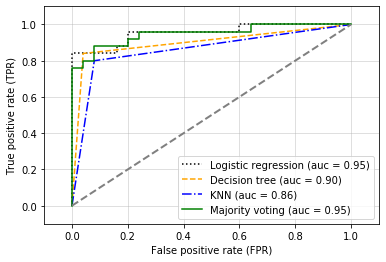

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # zakładamy, że etykieta klasy pozytywnej wynosi 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (Obszar auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Odsetek fałszywie pozytywnych (OFP)')
plt.ylabel('Odsetek prawdziwie pozytywnych (OPP)')


#plt.savefig('rysunki/07_04', dpi=300)
plt.show()

In [17]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

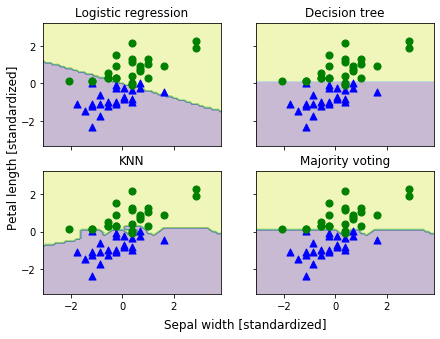

In [18]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Szerokość działki [standaryzowana]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Długość płatka [standaryzowana]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('rysunki/07_05', dpi=300)
plt.show()

In [19]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split

In [20]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    iid=False,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


/Users/sebastian/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [21]:
print('Najlepsze parametry: %s' % grid.best_params_)
print('Dokładność: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Accuracy: 0.98


**Uwaga**  
Domyślnym ustawieniem funkcji ` refit ` w klasie `GridSearchCV` jest `True` (np. `GridSeachCV(..., refit=True)`), co oznacza, że stosowany jest dopasowany estymator `GridSearchCV` wykonujący prognozy za pomocą metody `predict`, np:

    grid = GridSearchCV(estimator=mv_clf, 
                        param_grid=params, 
                        cv=10, 
                        scoring='roc_auc')
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

Dodatkowo możemy w bezpośredni sposób uzyskać dostęp do "najlepszego" estymatora poprzez atrybut `best_estimator_`.

In [22]:
grid.best_estimator_.classifiers

[Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False)]],
          verbose=False),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_f

In [23]:
mv_clf = grid.best_estimator_

In [24]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                             steps=[('sc',
                                                     StandardScaler(copy=True,
                                                                    with_mean=True,
                                                                    with_std=True)),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                               

In [25]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                             steps=[('sc',
                                                     StandardScaler(copy=True,
                                                                    with_mean=True,
                                                                    with_std=True)),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                               

<br>
<br>

# Agregacja — tworzenie zespołu klasyfikatorów za pomocą próbek początkowych

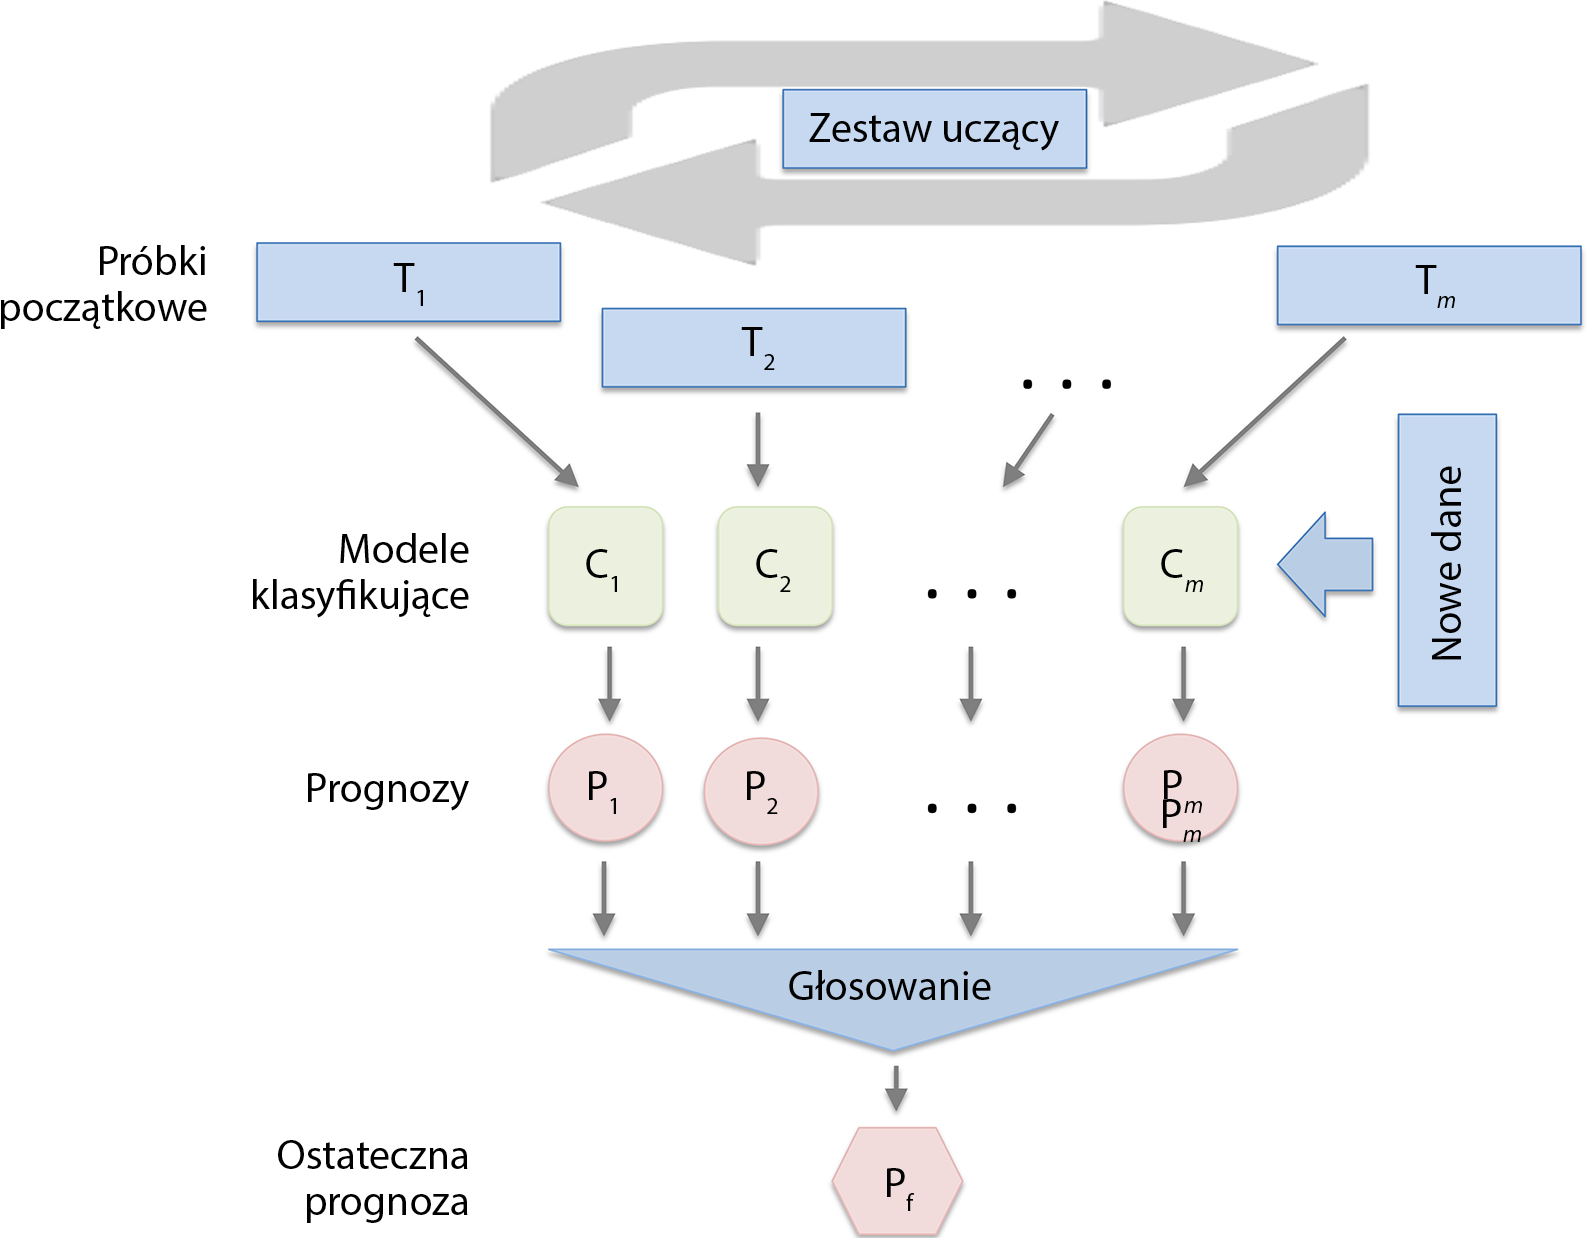

In [5]:
Image(filename='./rysunki/07_06.png', width=500) 

## Agregacja w pigułce

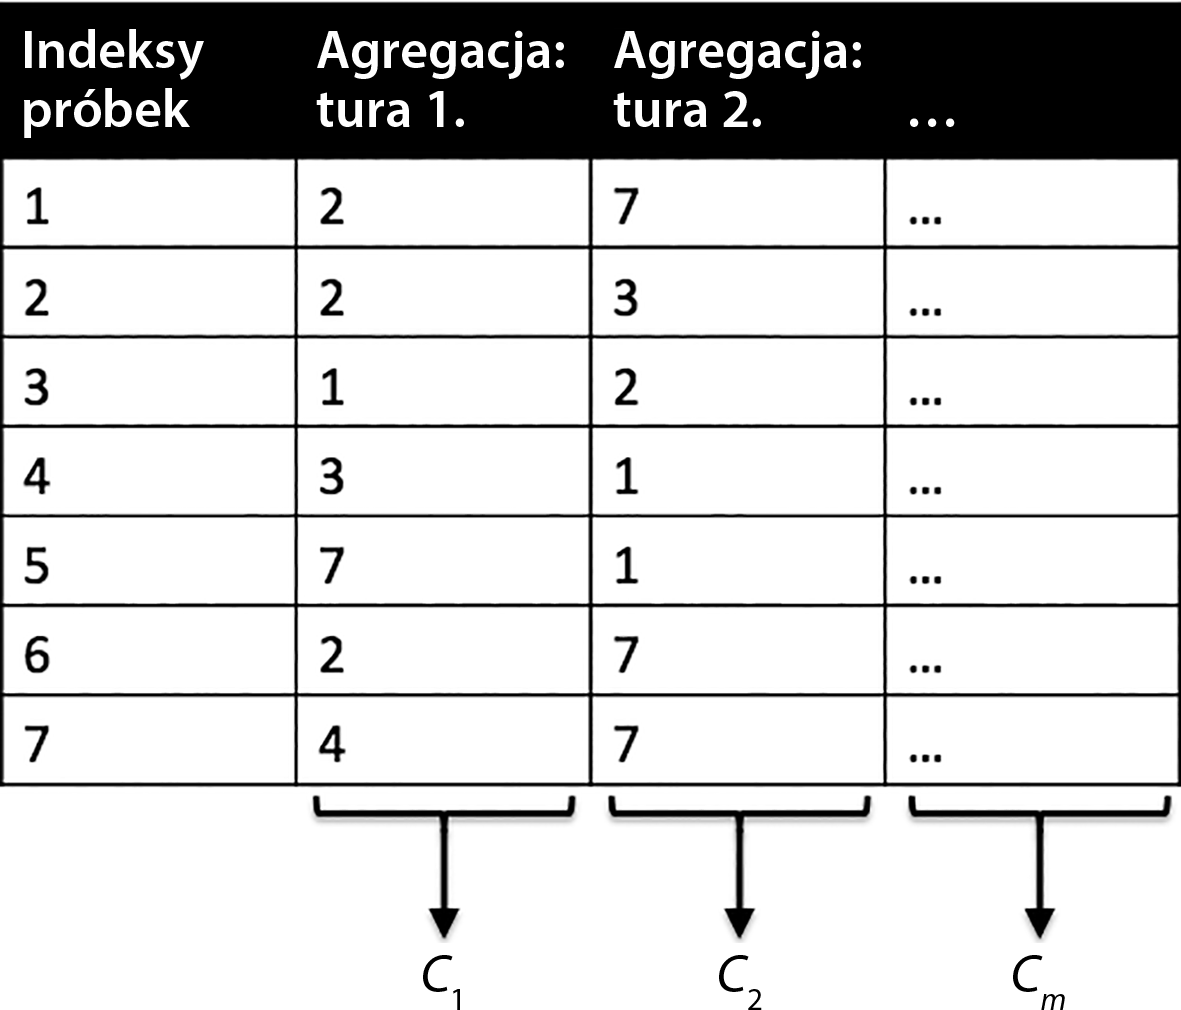

In [6]:
Image(filename='./rysunki/07_07.png', width=400) 

## Stosowanie agregacji do klasyfikowania przykładów z zestawu Wine

In [28]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Etykieta klas', 'Alkohol', 'Kwas jabłkowy', 'Popiół', 
'Zasadowość popiołu', 'Magnez', 'Całk. zaw. fenoli', 
'Flawonoidy', 'Fenole nieflawonoidowe', 'Proantocyjaniny', 
'Intensywność koloru', 'Odcień', 'Transmitancja 280/315 nm', 'Prolina']

# jeżeli zestaw danych Wine będzie tymczasowo niedostępny w repozytorium
# UCI, usuń znak komentarza w poniższym wierszu, aby wczytać zestaw danyych
# z katalogu lokalnego:

# df_wine = pd.read_csv('wine.data', header=None)

# porzuca klasę 1.
df_wine = df_wine[df_wine['Etykieta klas'] != 1]

y = df_wine['Etykieta klas'].values
X = df_wine[['Alkohol', 'Transmitancja 280/315 nm']].values

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [31]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Dokładność drzewa decyzyjnego dla danych uczących/testowych %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Dokładność agregacji dla danych uczących/testowych %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


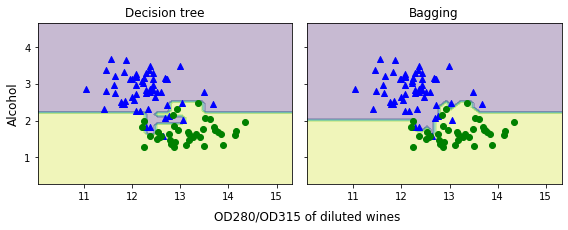

In [32]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Drzewo decyzyjne', 'Agregacja']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alkohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Transmitancja 280/315 nm',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('rysunki/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

<br>
<br>

# Usprawnianie słabych klasyfikatorów za pomocą wzmocnienia adaptacyjnego

## Wzmacnianie — mechanizm działania

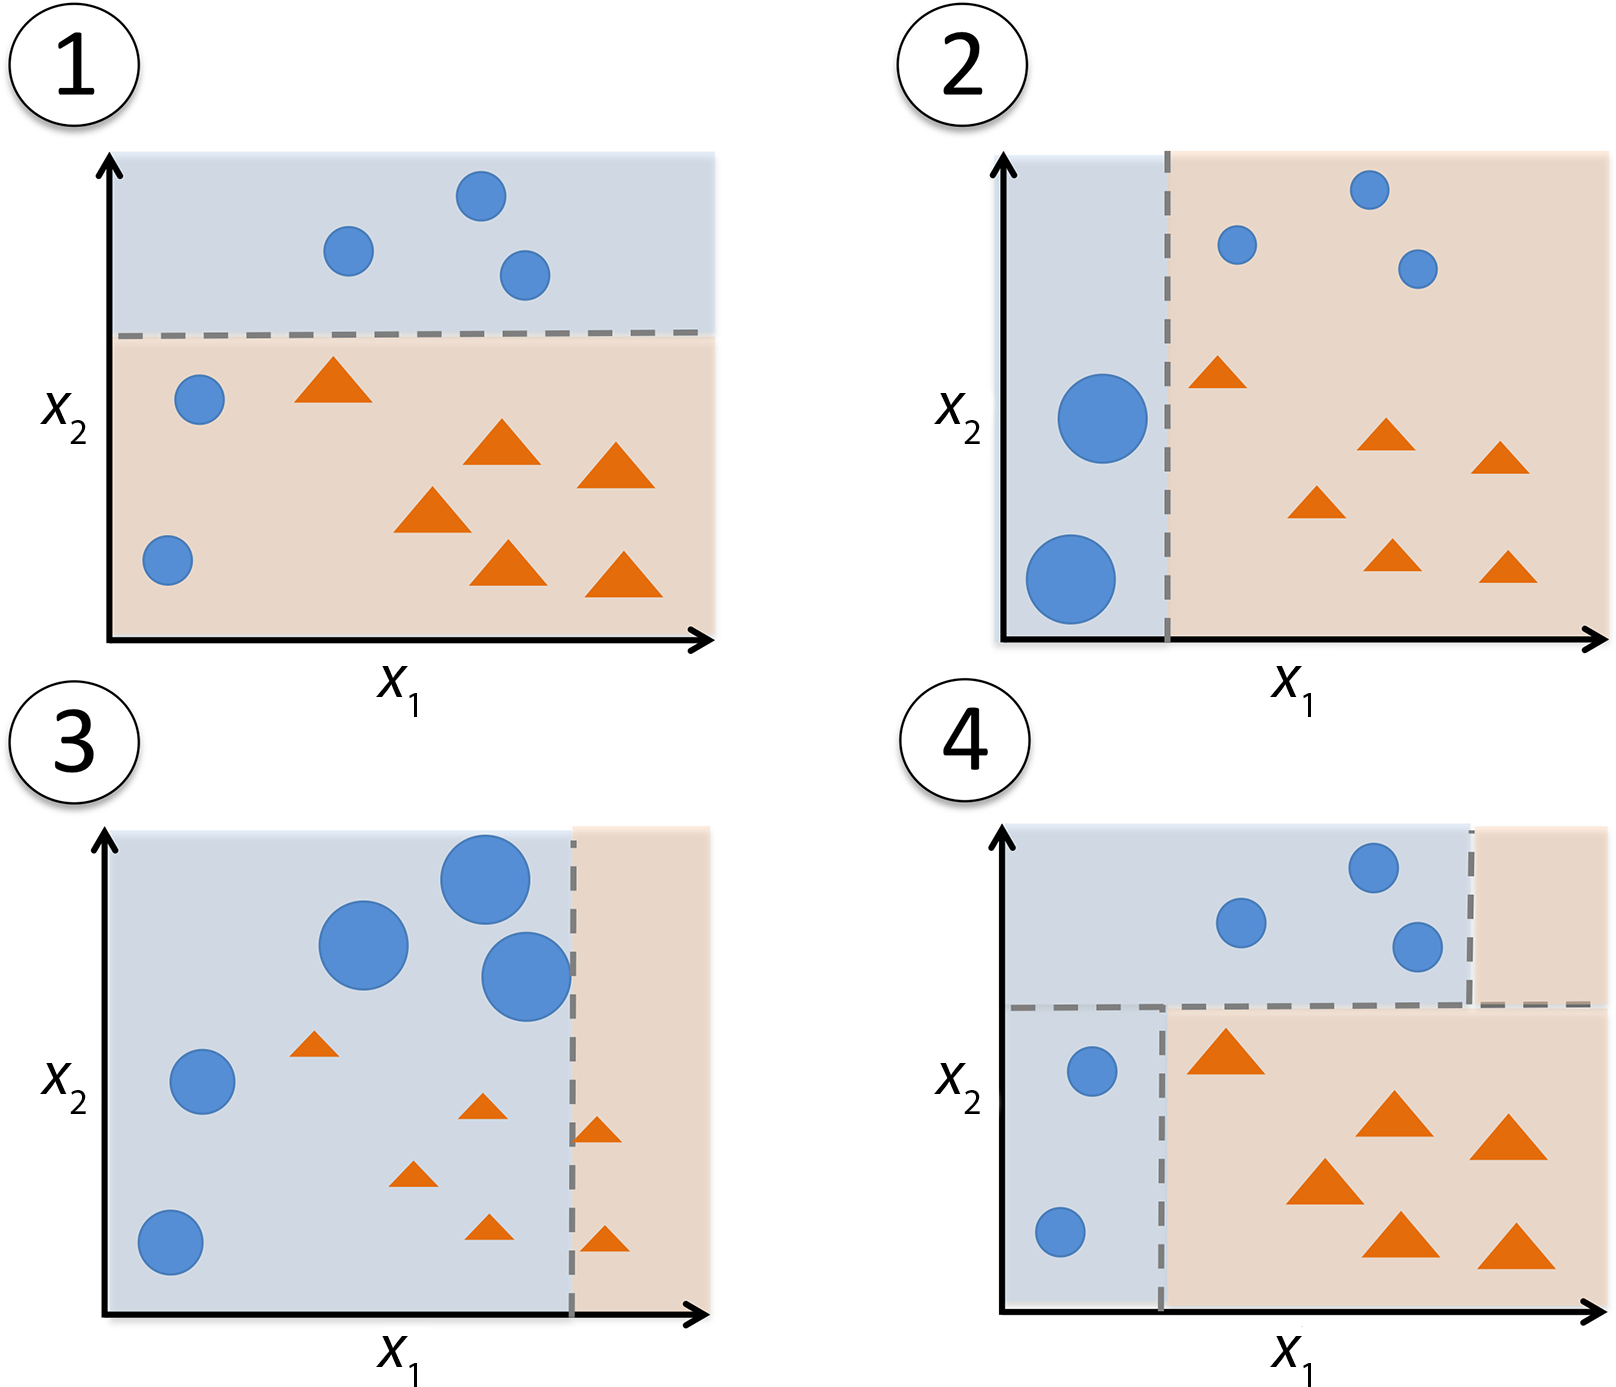

In [7]:
Image(filename='rysunki/07_09.png', width=400) 

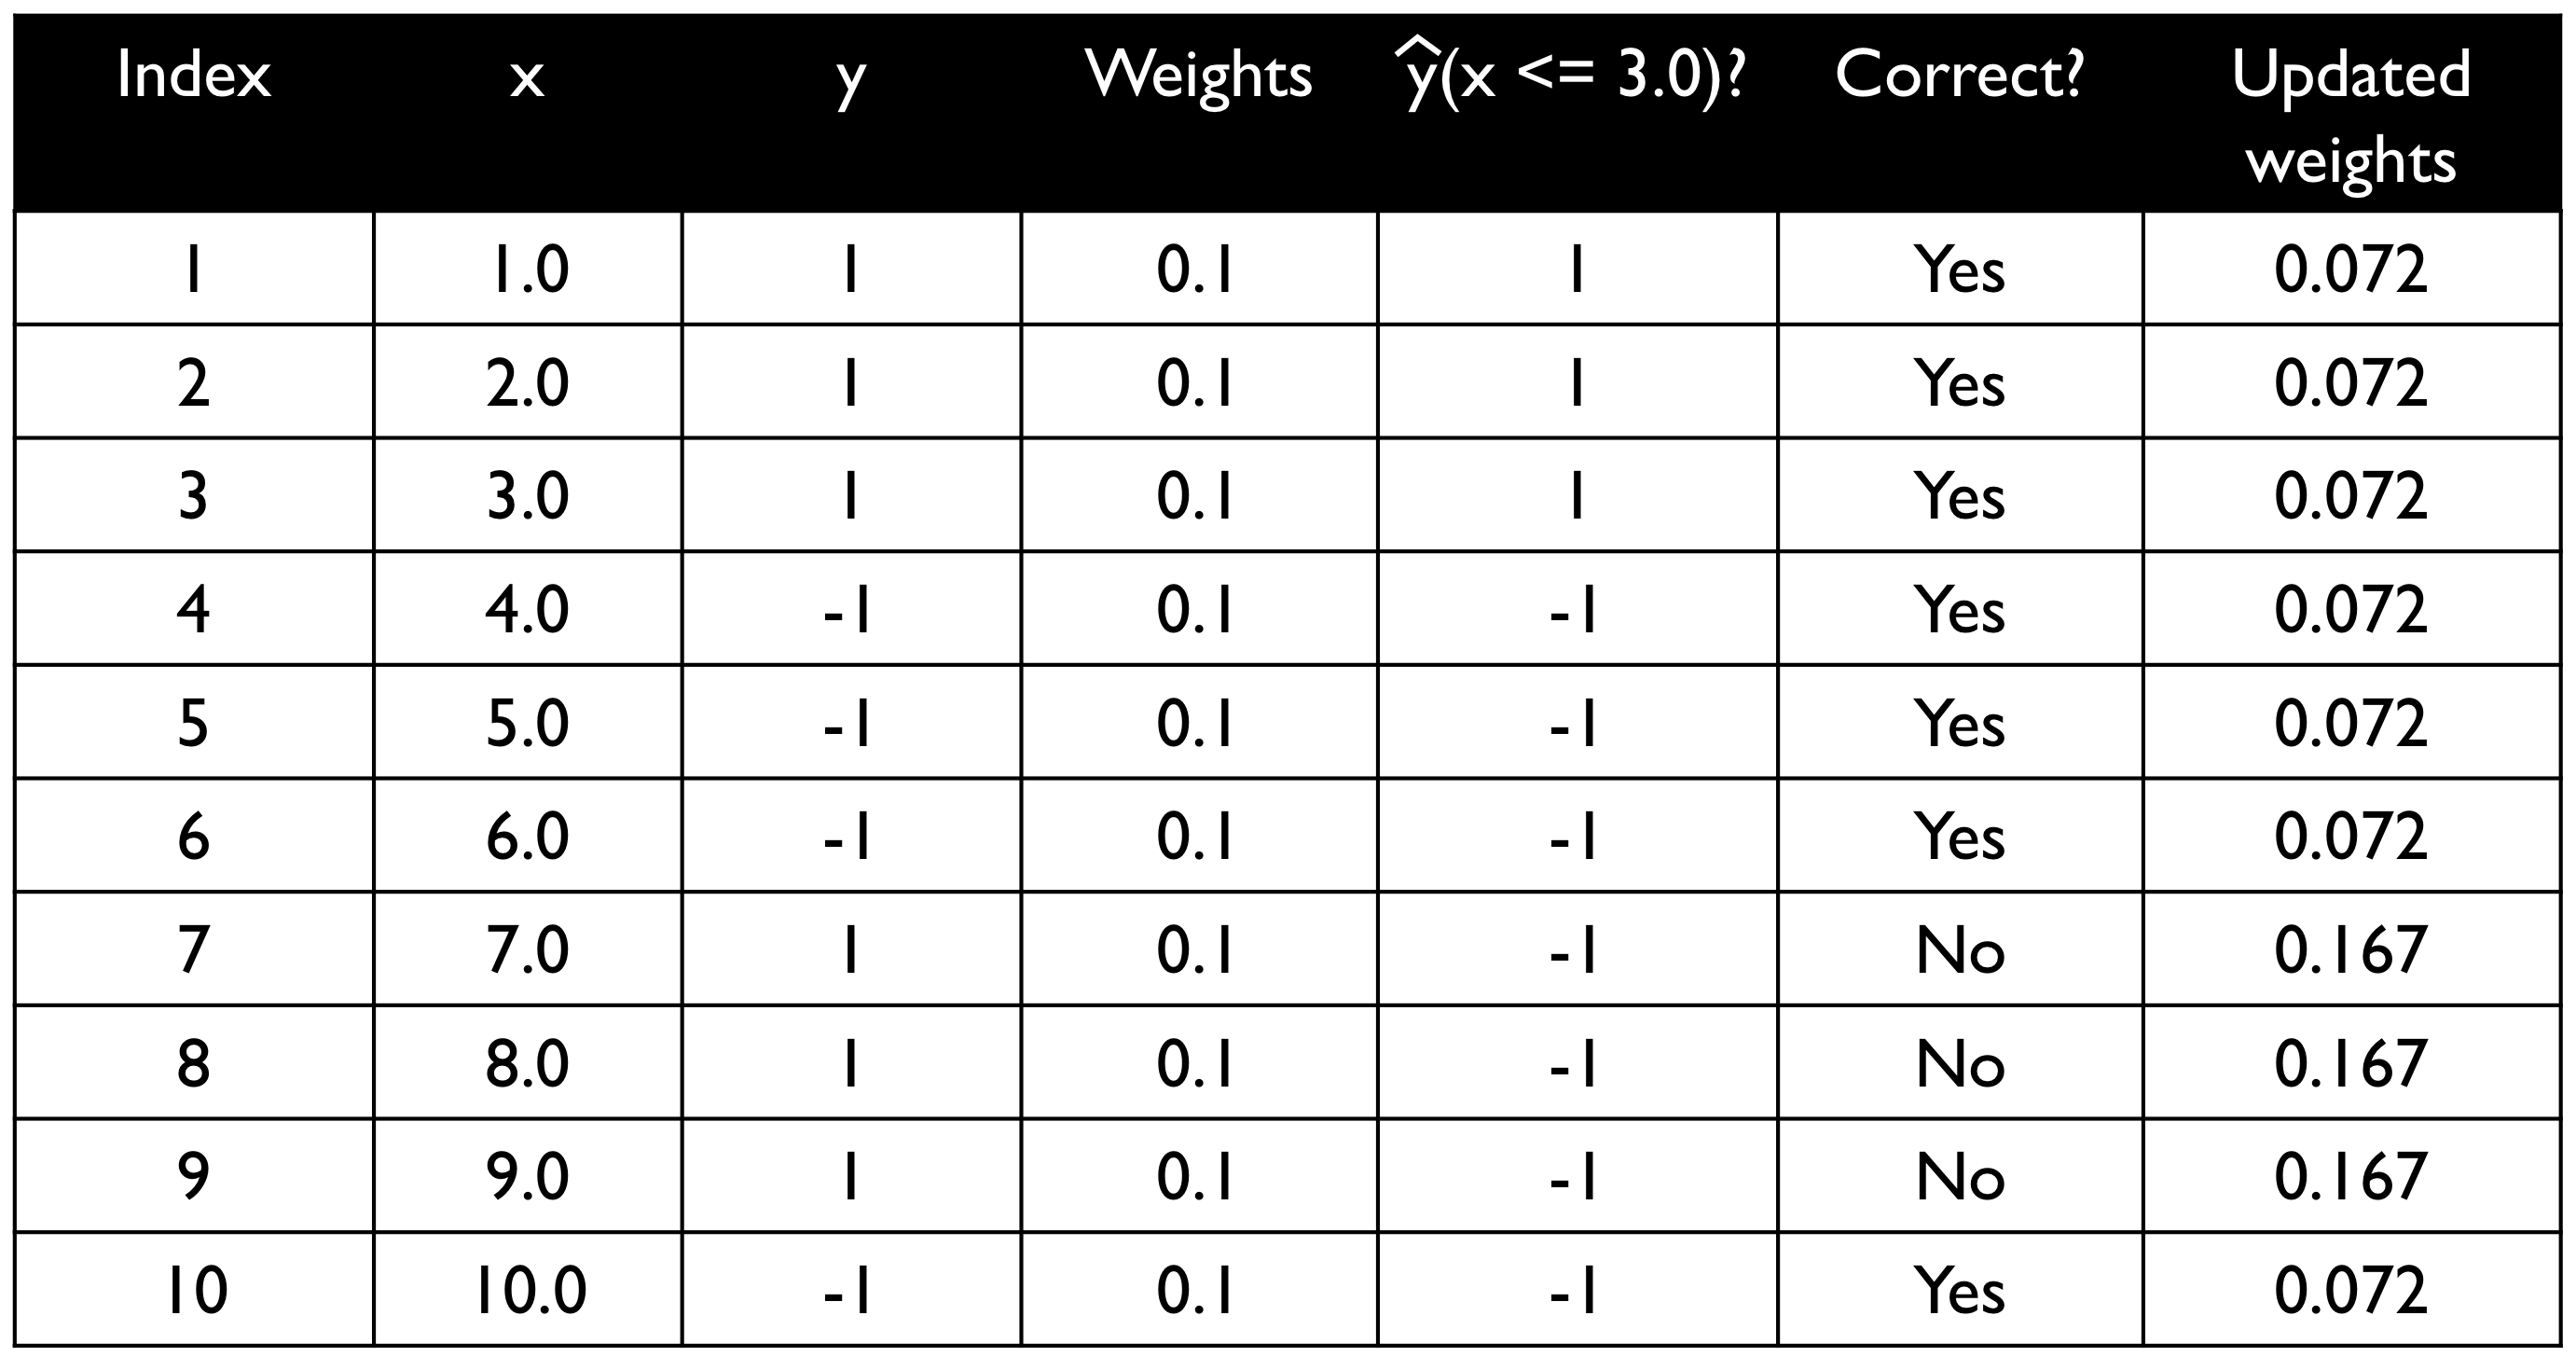

In [8]:
Image(filename='rysunki/07_10.png', width=500) 

## Stosowanie algorytmu AdaBoost za pomocą biblioteki scikit-learn

In [35]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [36]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Dokładność drzewa decyzyjnego dla danych uczących/testowych %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('Dokładność algorytmu AdaBoost dla danych uczących/testowych %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


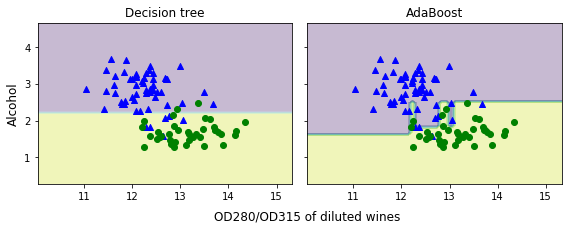

In [37]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Drzewo decyzyjne', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alkohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Transmitancja 280/315 nm',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('rysunki/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

<br>
<br>

# Podsumowanie

...

---

Czytelnicy mogą zignorować poniższą komórkę.

In [38]:
! python ../.convert_notebook_to_script.py --input r07.ipynb --output r07.py

[NbConvertApp] Converting notebook ch07.ipynb to script
[NbConvertApp] Writing 22375 bytes to ch07.py
